In [ ]:
!pip install wandb

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import os

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import datetime as dt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, TimeDistributed, \
    BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import wandb
from wandb.keras import WandbCallback


In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (20,12)

In [ ]:
random.seed(hash("random seed") % 2**32 - 1)
np.random.seed(hash("numpy seed") % 2**32 - 1)
tf.random.set_seed(hash("tensorflow seed") % 2**32 - 1)

In [ ]:
wandb.login()

True

In [ ]:
def ts_offset_split(dataframe, steps, lookback, horizon, batch_size, scaler='standard'):
    start = 0
    end = 168
    offset = 24
    training = []
    validation = []

    for i in range(int((365+366)/8)):

        train = dataframe.iloc[start:end]
        val = dataframe.iloc[end:end+offset]
        training.append(train)
        validation.append(val)

        start += 192
        end += 192
    
    # Decide Splits for sets
    train = pd.concat(training)

    val = pd.concat(validation)
    train = train.append(dataframe[(dataframe.index.date > val.index.max()) & (dataframe.index.date < dt.date(2021,1,1))])

    test = dataframe[dataframe.index.date >= dt.date(2021,1,1)]
    
    tmpdf = pd.concat([train,val,test])

    # Scaler
    if scaler == 'standard':
        X_scaler = StandardScaler()
        y_scaler = StandardScaler()
    elif scaler == 'minmax':
        X_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()
    else:
        print("Please specify one of 'standard' or 'minmax' to scaler parameter.")
    
    # Training
    start = lookback + horizon
    end = start + train.shape[0]

    X_train = train.values
    y_train = tmpdf.iloc[start:end][['Value']]

    X_train = X_scaler.fit_transform(X_train)
    y_train = y_scaler.fit_transform(y_train)

    # Validation
    x_end = len(val) - lookback - horizon
    y_val_start = train.shape[0] + lookback + horizon

    X_val = val.iloc[:x_end]
    y_val = tmpdf.iloc[y_val_start:y_val_start+x_end][['Value']]

    X_val = X_scaler.transform(X_val)
    y_val = y_scaler.transform(y_val)

    # Test
    x_end = len(test) - lookback - horizon
    y_test_start = (train.shape[0] + val.shape[0]) + lookback + horizon

    X_test = test.iloc[:x_end]
    y_test = tmpdf.iloc[y_test_start:y_test_start+x_end][['Value']]

    X_test = X_scaler.transform(X_test)
    y_test = y_scaler.transform(y_test)

    # Batch Sequence Generators
    sequence_length = int(lookback/steps)

    dataset_train = timeseries_dataset_from_array(
        X_train, y_train,
        sequence_length=sequence_length,
        sampling_rate=steps,
        batch_size=batch_size,
        shuffle=True
    )

    dataset_val = timeseries_dataset_from_array(
        X_val, y_val,
        sequence_length=sequence_length,
        sampling_rate=steps,
        batch_size=batch_size,
        shuffle=True
    )    

    dataset_test = timeseries_dataset_from_array(
        X_test, y_test,
        sequence_length=sequence_length,
        sampling_rate=steps,
        batch_size=batch_size,
        shuffle=False
    )    

    return dataset_train, dataset_val, dataset_test

In [ ]:
def load_data(config, splitmethod):
    # Load csv & parse dates to datetime index
    data = pd.read_csv(f'/content/drive/MyDrive/Thesis/{config.dataset}_features.csv', index_col='Datetime', parse_dates=['Datetime'])
    # Select Features
    data = data[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs', 'wkdy_sin', 'wkdy_cos', 'wknd', 'mnth_sin', 'mnth_cos']]
    
    if splitmethod == 'offset':
        train, val, test = ts_offset_split(data, 
                                  steps=steps, lookback=config.lookback, 
                                  horizon=horizon, batch_size=config.batch_size, 
                                  scaler='standard')
    
    elif splitmethod == 'standard':
        train, val, test = create_datasets(data, split=config.splitrate, 
                                  steps=steps, lookback=config.lookback, 
                                  horizon=horizon, batch_size=config.batch_size, 
                                  scaler='standard')
    
    return train, val, test
    
    
def build_model(config):
        
    model = Sequential()

    model.add(Input(shape=(config.lookback, config.num_features)))

    # CNN Block
    model.add(Conv1D(filters=config.cnn_layer_size_1, kernel_size=config.kernelsize, activation=config.activation_cnn))
    model.add(MaxPooling1D(pool_size=2))
    
    # RNN Block  
    model.add(GRU(config.gru_layer_size_1, return_sequences=False, activation=config.activation_gru))
    model.add(Dropout(config.dropout))

    model.add(Dense(1))
    
    opt = config.optimizer
    if opt == 'sgd':
        optimizer = SGD(learning_rate=config.learning_rate, momentum=config.momentum)
        
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

def log_defaults():
    # Default values from the first sweep
    # The following values resulted in the strongest model
    wandb_config = {
        'num_features' : 9,
        'epochs' : 100,
        'batch_size' : 224,
        'optimizer' : 'sgd',
        'dropout' : 0.2,
        'lookback' : 744,
        'activation_cnn' : 'relu',
        'activation_gru' : 'tanh',
        'kernelsize': 3,
        'cnn_layer_size_1' : 56,
        'gru_layer_size_1' : 96,
        'learning_rate' : 0.04,
        'momentum' : 0.9,
        'dataset' : 'kolding',
        'splitrate': 0.8,
        'splitmethod': 'offset',
        
    }
    return wandb_config



In [ ]:
# Additional Parameters
steps = 1 # timesteps: 1 hour
horizon = 1 # the target hour in the future we want to predict 1 hour ahead


In [ ]:
kld_data = pd.read_csv(f'/content/drive/MyDrive/Thesis/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])

start = 0
end = 168
offset = 24
training = []
validation = []

for i in range(int((365+366)/8)):

    kld_train = kld_data.iloc[start:end]
    kld_val = kld_data.iloc[end:end+offset]
    training.append(kld_train)
    validation.append(kld_val)

    start += 192
    end += 192

# Decide Splits for sets
kld_train = pd.concat(training)

kld_val = pd.concat(validation)
kld_train = kld_train.append(kld_data[(kld_data.index.date > kld_val.index.max()) & (kld_data.index.date < dt.date(2021,1,1))])

kld_test = kld_data[kld_data.index.date >= dt.date(2021,1,1)]

train_floats = kld_train[['Value']].to_numpy()
train_mean = train_floats.mean(axis=0)
train_floats -= train_mean
train_std = train_floats.std(axis=0)
train_floats /= train_std

print(f'Standardized Mean: {train_mean},\nStandardized Std: {train_std},\nStandardized Head: {train_floats[:5]}')

Standardized Mean: [87.50684772],
Standardized Std: [31.31291841],
Standardized Head: [[ 0.92023209]
 [ 0.48459719]
 [ 0.2833384 ]
 [-0.06881657]
 [-0.40446079]]


In [ ]:
wandb.init(config=log_defaults(), group='cnnrnn-final-train-kolding', project='thesis')

model = build_model(config=wandb.config)

train, val, test = load_data(config=wandb.config, splitmethod=wandb.config.splitmethod)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5)

ckpt_path = "/content/drive/MyDrive/Thesis/cnngru_final-kolding.h5"
estp = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

callbacks = [WandbCallback(), reduce_lr, ckpt, estp]

history = model.fit(
    train,
    epochs=wandb.config.epochs,
    validation_data=val,
    callbacks=callbacks
)

eval = model.evaluate(test)
wandb.log({'test_loss': eval[0]})
wandb.log({'test_mae': eval[1]})
print(f'\nTest Loss: {eval[0]} - Test MAE: {eval[1]}')


Epoch 1/100
66/66 [==============================] - 6s 68ms/step - loss: 0.6075 - mae: 0.5951 - val_loss: 0.4232 - val_mae: 0.4649

Epoch 00001: val_loss improved from inf to 0.42316, saving model to /content/drive/MyDrive/Thesis/cnngru_final-kolding.h5
Epoch 2/100
66/66 [==============================] - 4s 63ms/step - loss: 0.3507 - mae: 0.4373 - val_loss: 0.3505 - val_mae: 0.4194

Epoch 00002: val_loss improved from 0.42316 to 0.35047, saving model to /content/drive/MyDrive/Thesis/cnngru_final-kolding.h5
Epoch 3/100
66/66 [==============================] - 4s 63ms/step - loss: 0.3151 - mae: 0.4181 - val_loss: 0.3505 - val_mae: 0.4233

Epoch 00003: val_loss did not improve from 0.35047
Epoch 4/100
66/66 [==============================] - 4s 63ms/step - loss: 0.2799 - mae: 0.3969 - val_loss: 0.3043 - val_mae: 0.4056

Epoch 00004: val_loss improved from 0.35047 to 0.30435, saving model to /content/drive/MyDrive/Thesis/cnngru_final-kolding.h5
Epoch 5/100
66/66 [========================

In [ ]:
wandb.finish()

In [ ]:
def plot_training(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = range(len(loss))
    
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "ro-", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

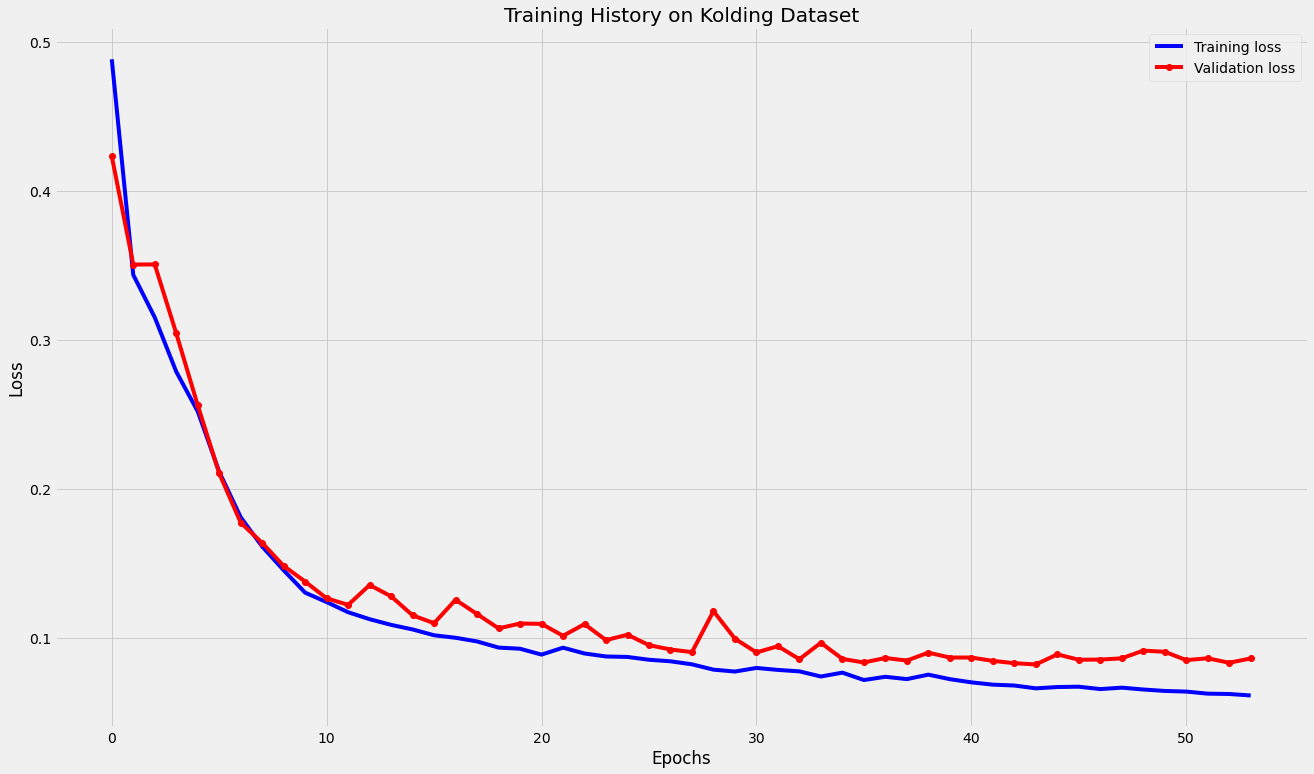

In [ ]:
plot_training(history, 'Training History on Kolding Dataset')

In [ ]:
pred = model.predict(test)

In [ ]:
inverse_scaled_pred = (pred * train_std) + train_mean
inverse_scaled_pred

array([[77.8251046 ],
       [81.42561599],
       [81.7422033 ],
       ...,
       [83.06950251],
       [77.77251891],
       [73.43640652]])

In [ ]:
y_true = kld_test.iloc[744+1:len(kld_test) - 744 + 1][['Value']]

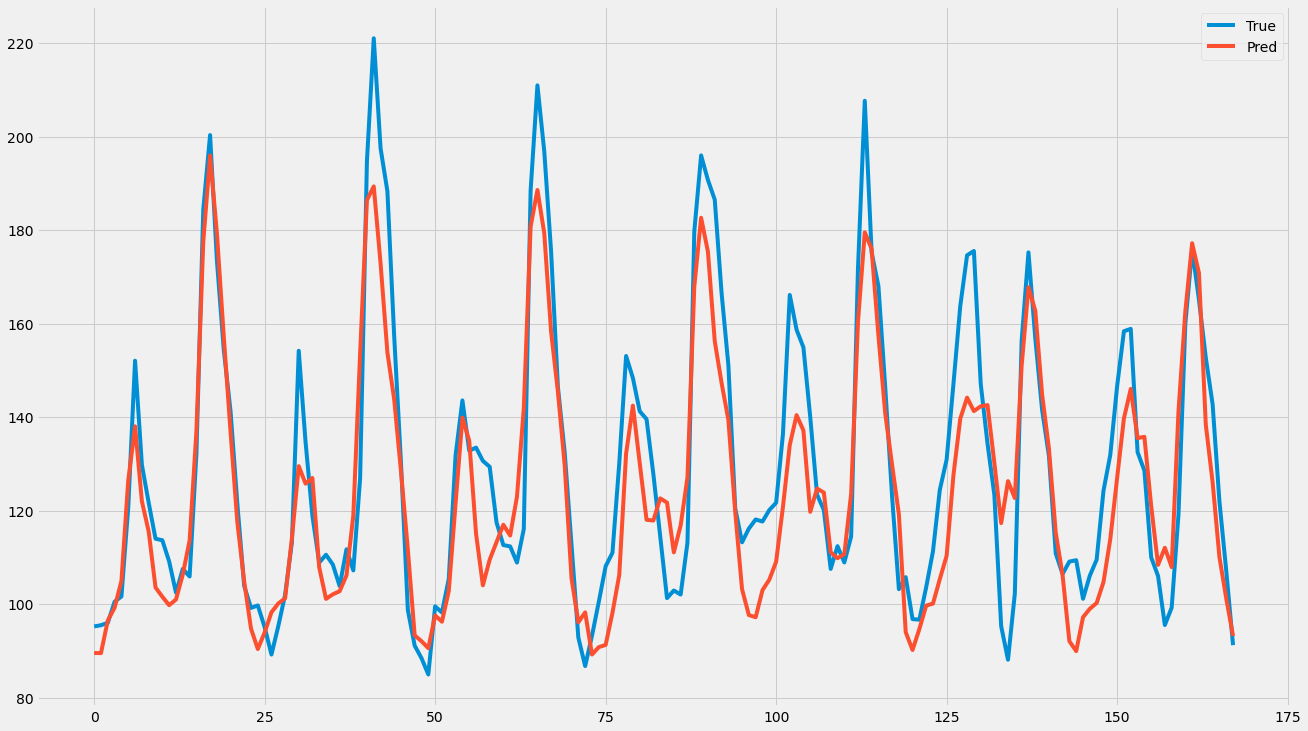

In [ ]:
plt.plot(y_true.iloc[168:2*168].values, label='True')
plt.plot(inverse_scaled_pred[168:2*168], label='Pred')
plt.legend()

In [ ]:
pred_df = y_true.copy()
pred_df.rename(columns={'Value':'True'}, inplace=True)
pred_df['Pred'] = inverse_scaled_pred

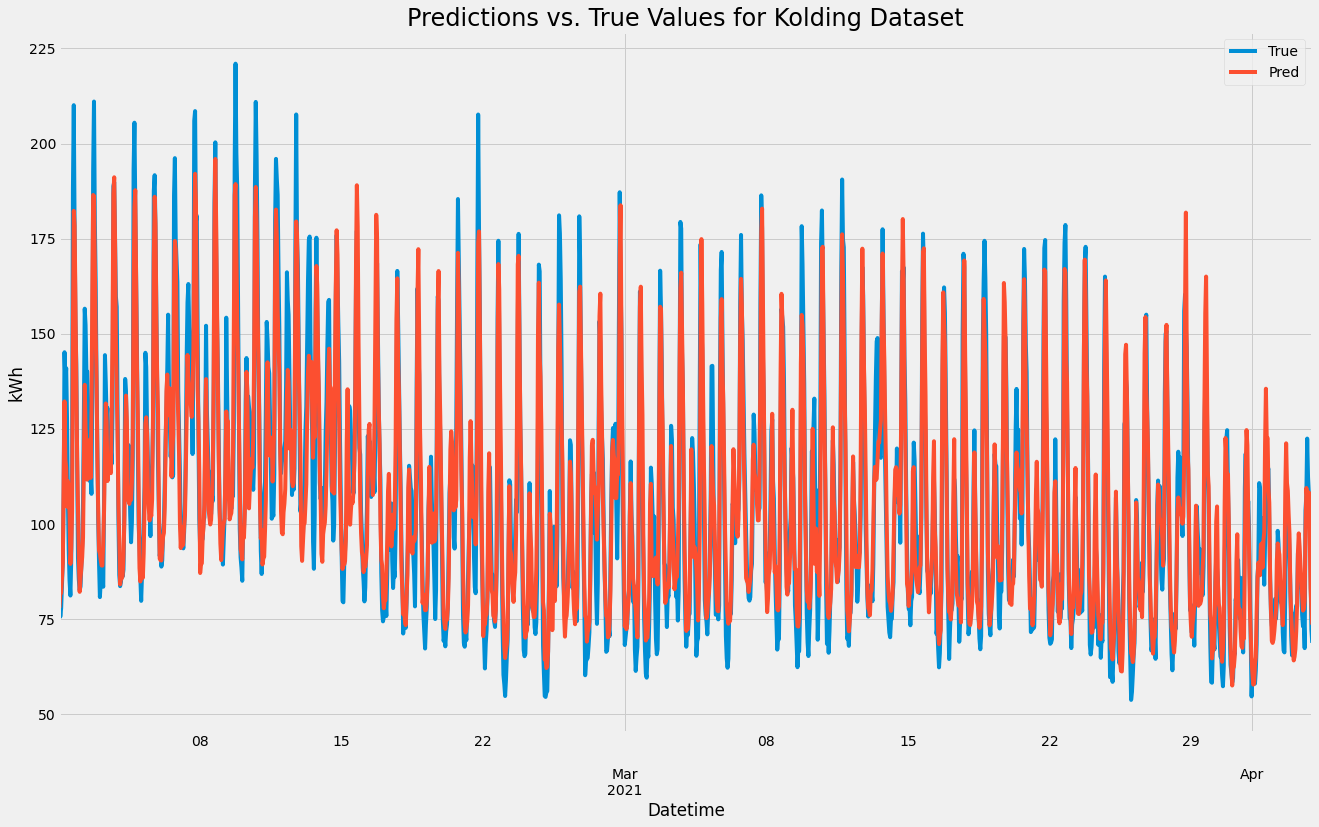

In [ ]:
ax = pred_df.plot()
ax.set_title('Predictions vs. True Values for Kolding Dataset', fontsize=24)
ax.set_ylabel('kWh')
plt.savefig('/content/drive/MyDrive/Thesis/pred_vs_true_full_kolding.png', bbox_inches='tight')
plt.show()

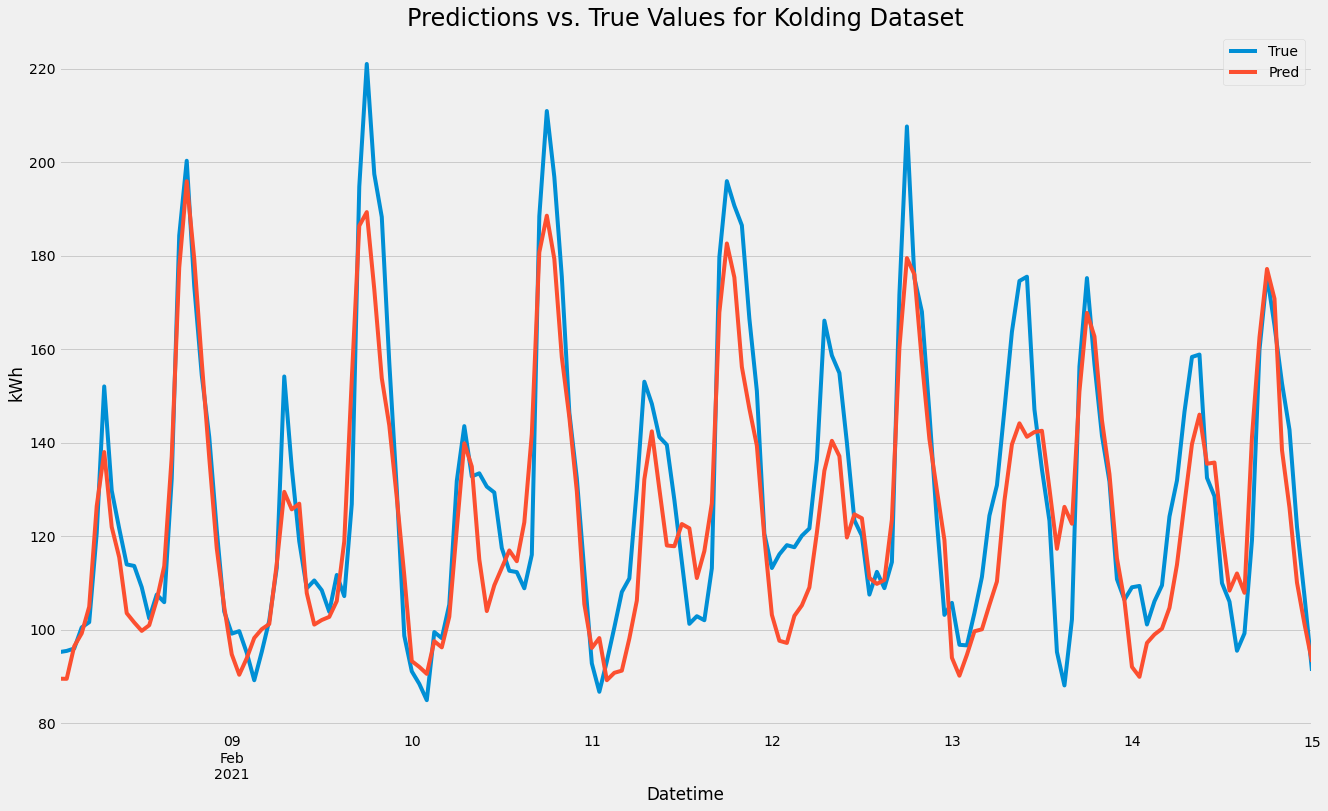

In [ ]:
ax = pred_df.loc[dt.date(2021, )].plot()
ax.set_title('Predictions vs. True Values for Kolding Dataset', fontsize=24)
ax.set_ylabel('kWh')
#plt.savefig('/content/drive/MyDrive/Thesis/pred_vs_true_full_kolding.png', bbox_inches='tight')
plt.show()

In [ ]:
np.mean(np.abs(inverse_scaled_pred - y_true.values))

8.343868438148526

In [ ]:
np.mean(np.abs((y_true.values - inverse_scaled_pred) / y_true.values)) * 100

7.967482558541604

In [ ]:
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
def metrics(true, pred):
    print(f'MSE: {np.mean(mean_squared_error(true, pred))}')
    print(f'RMSE: {np.sqrt(np.mean(mean_squared_error(true, pred)))}')
    print(f'MAE: {np.mean(mean_absolute_error(true, pred))}')
    print(f'MAPE: {np.mean(mean_absolute_percentage_error(true, pred))}')

In [ ]:
metrics(y_true.values, inverse_scaled_pred)

MSE: 118.17333955414824
MAE: 8.343868438148526
MAPE: 7.967482558541604
